In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("../input/state-farm-distracted-driver-detection/imgs/train", output="./", seed=1337, ratio=(.7, .2, .1), group_prefix=None) # default values

Copying files: 22424 files [02:11, 170.18 files/s]


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

In [3]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 15692 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = InceptionV3(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

In [ ]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=15, callbacks=callback)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("InceptionV3_15_epoch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("InceptionV3_15_epoch.h5")
print("Saved model to disk")

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

# Xception

In [ ]:
md = Xception(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())

In [ ]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=15, callbacks=callback)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("xceptionV3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Xception.h5")
print("Saved model to disk")

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

# DenseNet501

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = DenseNet201(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

In [ ]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=15, callbacks=callback)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("DenseNet201.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DenseNet201.h5")
print("Saved model to disk")

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

# EfficientNetB6

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = EfficientNetB6(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

In [ ]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=15, callbacks=callback)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("EfficientNetB6.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("EfficientNetB6.h5") 
print("Saved model to disk")

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

# MobileNet

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = MobileNet(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 3,239,114
Trainable params: 3,217,226
Non-trainable params: 21,888
_________________________________________________________________
None


In [5]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=20, callbacks=callback)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
653/653 [==============================] - 138s 199ms/step - loss: 1.7873 - accuracy: 0.4494 - val_loss: 0.3516 - val_accuracy: 0.9483
Epoch 2/20
653/653 [==============================] - 129s 198ms/step - loss: 0.2959 - accuracy: 0.9590 - val_loss: 0.1306 - val_accuracy: 0.9792
Epoch 3/20
653/653 [==============================] - 128s 196ms/step - loss: 0.1201 - accuracy: 0.9856 - val_loss: 0.0703 - val_accuracy: 0.9886
Epoch 4/20
653/653 [==============================] - 129s 197ms/step - loss: 0.0681 - accuracy: 0.9914 - val_loss: 0.0445 - val_accuracy: 0.9919
Epoch 5/20
653/653 [==============================] - 129s 197ms/step - loss: 0.0386 - accuracy: 0.9967 - val_loss: 0.0321 - val_accuracy: 0.9942
Epoch 6/20
653/653 [==============================] - 129s 197ms/step - loss: 0.0246 - accuracy: 0.9985 - val_loss: 0.0238 - val_accuracy: 0.9953
Epoch 7/20
653/653 [==============================] - 127s 195ms/step - loss: 0.0165 - accuracy: 0.9994 - val_loss: 0.0194 -

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("MobileNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("MobileNet.h5") 
print("Saved model to disk")

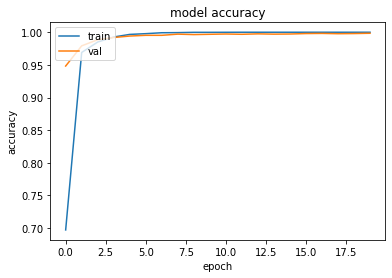

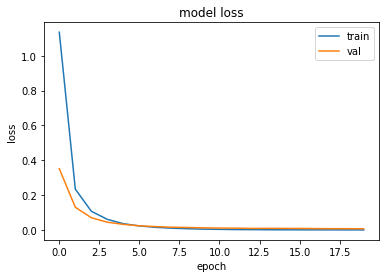

In [6]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Found 2251 images belonging to 10 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


93/93 [==============================] - 13s 131ms/step
               Filename Predictions
0     c0/img_100026.jpg          c0
1       c0/img_1005.jpg          c0
2     c0/img_101175.jpg          c0
3     c0/img_102087.jpg          c0
4      c0/img_10225.jpg          c0
...                 ...         ...
2246   c9/img_96905.jpg          c9
2247   c9/img_97889.jpg          c9
2248   c9/img_98514.jpg          c9
2249    c9/img_9877.jpg          c9
2250   c9/img_99212.jpg          c9

[2251 rows x 2 columns]
2249 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       228
           2       1.00      1.00      1.00       233
           3       1.00      1.00      1.00       235
           4       1.00      1.00      1.00       233
           5       1.00      1.00      1.00       232
           6       1.00      1.00      1.00       233
           7       1.00      1.00      1.00    

<AxesSubplot:>

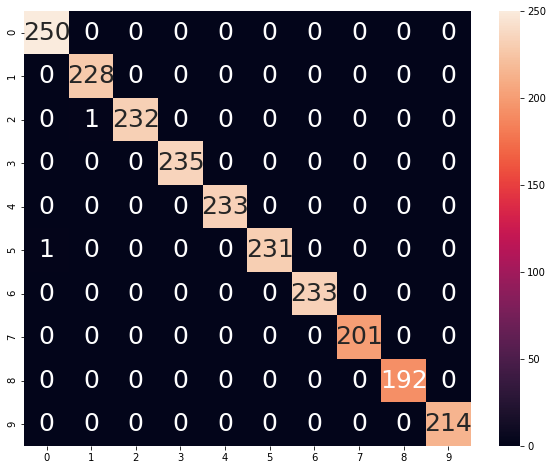

In [7]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

# ResNet50

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = ResNet50(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

In [ ]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=15, callbacks=callback)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("ResNet50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("ResNet50.h5")
print("Saved model to disk")

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')